### 食用/毒キノコの非線形分類
<b>
作成者：鍋 知宏<br>
<br>
【kaggle課題】<br>
Mushroom Classification<br>
https://www.kaggle.com/uciml/mushroom-classification/data

<br>
【課題内容】<br>
キノコの特徴を表すデータセット内において、どの特徴が食用であることを示し、<br>
どの特徴が毒であることを示すのか提示する。<br>
<br>
1. データセットの確認<br>
2. データの読込<br>
3. 欠損値の確認<br>
4. 目的変数と説明変数の関係の可視化<br>
5. 分類アルゴリズムの検討<br>
6. 単純ベイズ
</b>


In [227]:
import pandas as pd
import numpy as np
from IPython.display import display
from dateutil.parser import parse
import matplotlib.pyplot as plt
from collections import OrderedDict
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score

### 1. データセットの確認
まずは、kaggle課題サイトの情報から各変数の意味を調べてみます。

In [74]:
lang_trans = {
    'classes':'分類クラス',
    'cap-shape':'かさの形状',
    'cap-surface':'かさの表面',
    'cap-color':'かさの色',
    'bruises':'きず',
    'odor':'におい',
    'gill-attachment':'ひだのつき方',
    'gill-spacing':'ひだの間隔',
    'gill-size':'ひだのサイズ',
    'gill-color':'ひだの色',
    'stalk-shape':'柄の形状',
    'stalk-root':'柄の根本',
    'stalk-surface-above-ring':'柄の表面(つばの上方部)',
    'stalk-surface-below-ring':'柄の表面(つばの下方部)',
    'stalk-color-above-ring':'柄の色(つばの上方部)',
    'stalk-color-below-ring':'柄の色(つばの下方部)',
    'veil-type':'つぼのタイプ',
    'veil-color':'つぼの色',
    'ring-number':'つばの数',
    'ring-type':'つばのタイプ',
    'spore-print-color':'胞子紋の色',
    'population':'集団形成',
    'habitat':'生息地'
}
data_items = {
    'classes':{'e':'食用キノコ', 'p':'毒キノコ'},
    'cap-shape':{'b':'ベル型', 'c':'円錐型', 'x':'饅頭型','f':'扁平型', 'k':'こぶ型', 's':'凹型'},
    'cap-surface':{'f':'繊維状', 'g':'溝状', 'y':'鱗片状', 's':'平滑状'},
    'cap-color':{'n':'茶色', 'b':'淡黄色', 'c':'シナモン色', 'g':'灰色', 'r':'緑色', 'p':'ピンク色', 'u':'紫色', 'e':'赤色'},
    'bruises':{'t':'あり', 'f':'なし'},
    'odor':{'a':'アーモンド臭', 'l':'アニス臭', 'c':'クレオソート臭', 'y':'魚臭', 'f':'悪臭', 'm':'かび臭', 'n':'無臭', 'p':'刺激臭', 's':'スパイシー臭',},
    'gill-attachment':{'a':'直性', 'd':'垂性', 'f':'離生', 'n':'湾生'},
    'gill-spacing':{'c':'近い', 'w':'密な', 'd':'遠い'},
    'gill-size':{'b':'広い', 'n':'狭い'},
    'gill-color':{'k':'黒色', 'n':'茶色', 'b':'淡黄色', 'h':'チョコレート色', 'g':'灰色', 'r':'緑色', 'o':'オレンジ色', 'p':'ピンク色', 'u':'紫色', 'e':'赤色', 'w':'白色', 'y':'黄色'},
    'stalk-shape':{'e':'先太型', 't':'先細型'},
    'stalk-root':{'b':'球根状', 'c':'棍棒状', 'u':'カップ状', 'e':'扁平状', 'z':'根状菌糸束', 'r':'根状', '?':'欠損値'},
    'stalk-surface-above-ring':{'f':'繊維状', 'y':'鱗片状', 'k':'絹状', 's':'平滑状'},
    'stalk-surface-below-ring':{'f':'繊維状', 'y':'鱗片状', 'k':'絹状', 's':'平滑状'},
    'stalk-color-above-ring':{'n':'茶色', 'b':'淡黄色', 'c':'シナモン色', 'g':'灰色', 'o':'オレンジ色', 'p':'ピンク色', 'e':'赤色', 'w':'白色', 'y':'黄色'},
    'stalk-color-below-ring':{'n':'茶色', 'b':'淡黄色', 'c':'シナモン色', 'g':'灰色', 'o':'オレンジ色', 'p':'ピンク色', 'e':'赤色', 'w':'白色', 'y':'黄色'},
    'veil-type':{'p':'部分型', 'u':'全体型'},
    'veil-color':{'n':'茶色', 'o':'オレンジ色', 'w':'白色', 'y':'黄色'},
    'ring-number':{'n':'なし', 'o':'1', 't':'2'},
    'ring-type':{'c':'クモの巣型', 'e':'一過型', 'f':'口広がり型', 'l':'大型', 'n':'なし', 'p':'ペンダント型', 's':'被覆型', 'z':'ゾーン型'},
    'spore-print-color':{'k':'黒色', 'n':'茶色', 'b':'淡黄色', 'h':'チョコレート色', 'r':'緑色', 'o':'オレンジ色', 'u':'紫色', 'w':'白色', 'y':'黄色'},
    'population':{'a':'豊富', 'c':'群生', 'n':'多数', 's':'散在', 'v':'少数', 'y':'単性'},
    'habitat':{'g':'芝生', 'l':'葉', 'm':'牧草地', 'p':'道路', 'u':'都市部', 'w':'廃棄物', 'd':'木'}
}

item_max_size = max([len(x) for x in data_items.values()])
data_set = OrderedDict()
for feature, items in data_items.items():
    key_feature = '{0}({1})'.format(feature, lang_trans[feature])
    data_set[key_feature] = []
    for label, item in items.items():
        value_item = "{0}({1})".format(label, item)
        data_set[key_feature].append(value_item)
    if len(data_set[key_feature]) < item_max_size:
        for i in enumerate(range(item_max_size - len(data_set[key_feature]))):
            data_set[key_feature].append('') 
data_set = pd.DataFrame.from_dict(data_set).T
data_set = data_set.style.set_properties(**{'text-align': 'left'})
display(data_set)


,0,1,2,3,4,5,6,7,8,9,10,11
classes(分類クラス),e(食用キノコ),p(毒キノコ),,,,,,,,,,
cap-shape(かさの形状),b(ベル型),c(円錐型),x(饅頭型),f(扁平型),k(こぶ型),s(凹型),,,,,,
cap-surface(かさの表面),f(繊維状),g(溝状),y(鱗片状),s(平滑状),,,,,,,,
cap-color(かさの色),n(茶色),b(淡黄色),c(シナモン色),g(灰色),r(緑色),p(ピンク色),u(紫色),e(赤色),,,,
bruises(きず),t(あり),f(なし),,,,,,,,,,
odor(におい),a(アーモンド臭),l(アニス臭),c(クレオソート臭),y(魚臭),f(悪臭),m(かび臭),n(無臭),p(刺激臭),s(スパイシー臭),,,
gill-attachment(ひだのつき方),a(直性),d(垂性),f(離生),n(湾生),,,,,,,,
gill-spacing(ひだの間隔),c(近い),w(密な),d(遠い),,,,,,,,,
gill-size(ひだのサイズ),b(広い),n(狭い),,,,,,,,,,
gill-color(ひだの色),k(黒色),n(茶色),b(淡黄色),h(チョコレート色),g(灰色),r(緑色),o(オレンジ色),p(ピンク色),u(紫色),e(赤色),w(白色),y(黄色)


### 属性情報からわかること
<b>
・本課題はキノコが食用キノコか毒キノコかの識別であるため、目的変数はclassesとなる。<br>
・属性要素はすべてアルファベット１文字のString型である。<br>
・属性『stalk-root(柄の根本)』の"?"は欠損値である。<br>
・各属性の要素は概ね独立性があり、名寄せの必要なさそうである。<br>
</b>

### 2. データ読込

In [75]:
df_data = pd.read_csv("mushrooms.csv")
display(df_data)
data_size = len(df_data)

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
5,e,x,y,y,t,a,f,c,b,n,...,s,w,w,p,w,o,p,k,n,g
6,e,b,s,w,t,a,f,c,b,g,...,s,w,w,p,w,o,p,k,n,m
7,e,b,y,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,s,m
8,p,x,y,w,t,p,f,c,n,p,...,s,w,w,p,w,o,p,k,v,g
9,e,b,s,y,t,a,f,c,b,g,...,s,w,w,p,w,o,p,k,s,m


データは8124件

### 3. 欠損値の確認
属性『stalk-root(柄の根本)』の欠損値は"?"でラベリングされているが、その他にデータがNullのレコードがないか確認する。

In [76]:
pd.concat([df_data.describe().T, pd.DataFrame(df_data.isnull().sum(), columns=["num of missing"])], axis=1)

,count,unique,top,freq,num of missing
class,8124,2,e,4208,0
cap-shape,8124,6,x,3656,0
cap-surface,8124,4,y,3244,0
cap-color,8124,10,n,2284,0
bruises,8124,2,f,4748,0
odor,8124,9,n,3528,0
gill-attachment,8124,2,f,7914,0
gill-spacing,8124,2,c,6812,0
gill-size,8124,2,b,5612,0
gill-color,8124,12,b,1728,0


Nullデータは存在しないことがわかる。

### 4. 目的変数と説明変数の関係
1. 各クラス（食用/毒キノコ)に対し、各変数の特徴カテゴリがどの程度のデータ量をしめているのが可視化する。
2. 各変数の特徴カテゴリごとに、食用/毒である確率のバランスを可視化する。

*========================================================================*
cap-shape(かさの形状)
b:ベル型, c:円錐型, x:饅頭型, f:扁平型, k:こぶ型, s:凹型, 
*========================================================================*


cap-shape,b,c,f,k,s,x,All
class,,,,,,,
e,404,0,1596,228,32,1948,4208
p,48,4,1556,600,0,1708,3916
All,452,4,3152,828,32,3656,8124


cap-shape,b,c,f,k,s,x,All
class,,,,,,,
e,4.97%,0.00%,19.65%,2.81%,0.39%,23.98%,51.80%
p,0.59%,0.05%,19.15%,7.39%,0.00%,21.02%,48.20%
All,5.56%,0.05%,38.80%,10.19%,0.39%,45.00%,100.00%


class,e,p,All
cap-shape,,,
All,51.80%,48.20%,100.00%
x,23.98%,21.02%,45.00%
f,19.65%,19.15%,38.80%
k,2.81%,7.39%,10.19%
b,4.97%,0.59%,5.56%
s,0.39%,0.00%,0.39%
c,0.00%,0.05%,0.05%


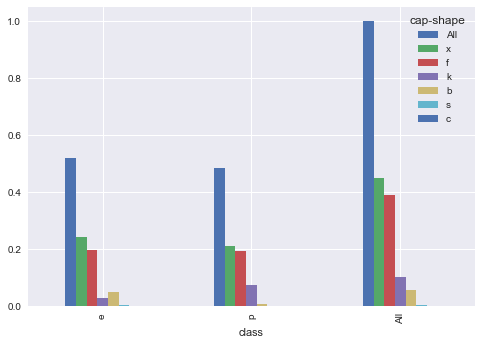

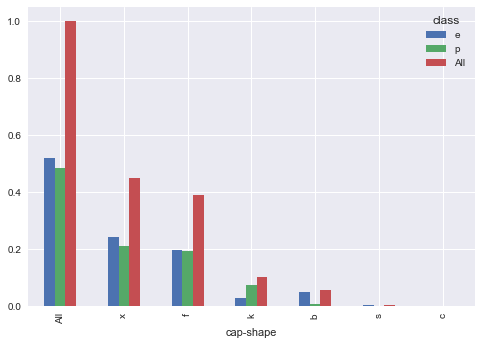

*========================================================================*
cap-surface(かさの表面)
f:繊維状, g:溝状, y:鱗片状, s:平滑状, 
*========================================================================*


cap-surface,f,g,s,y,All
class,,,,,
e,1560,0,1144,1504,4208
p,760,4,1412,1740,3916
All,2320,4,2556,3244,8124


cap-surface,f,g,s,y,All
class,,,,,
e,19.20%,0.00%,14.08%,18.51%,51.80%
p,9.35%,0.05%,17.38%,21.42%,48.20%
All,28.56%,0.05%,31.46%,39.93%,100.00%


class,e,p,All
cap-surface,,,
All,51.80%,48.20%,100.00%
y,18.51%,21.42%,39.93%
s,14.08%,17.38%,31.46%
f,19.20%,9.35%,28.56%
g,0.00%,0.05%,0.05%


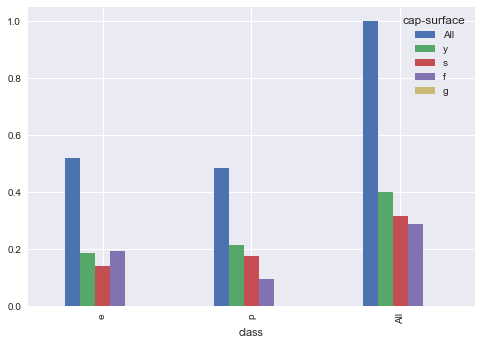

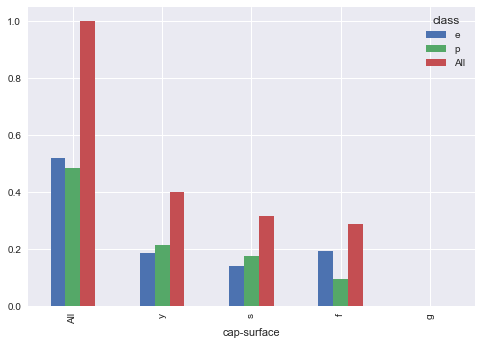

*========================================================================*
cap-color(かさの色)
n:茶色, b:淡黄色, c:シナモン色, g:灰色, r:緑色, p:ピンク色, u:紫色, e:赤色, 
*========================================================================*


cap-color,b,c,e,g,n,p,r,u,w,y,All
class,,,,,,,,,,,
e,48,32,624,1032,1264,56,16,16,720,400,4208
p,120,12,876,808,1020,88,0,0,320,672,3916
All,168,44,1500,1840,2284,144,16,16,1040,1072,8124


cap-color,b,c,e,g,n,p,r,u,w,y,All
class,,,,,,,,,,,
e,0.59%,0.39%,7.68%,12.70%,15.56%,0.69%,0.20%,0.20%,8.86%,4.92%,51.80%
p,1.48%,0.15%,10.78%,9.95%,12.56%,1.08%,0.00%,0.00%,3.94%,8.27%,48.20%
All,2.07%,0.54%,18.46%,22.65%,28.11%,1.77%,0.20%,0.20%,12.80%,13.20%,100.00%


class,e,p,All
cap-color,,,
All,51.80%,48.20%,100.00%
n,15.56%,12.56%,28.11%
g,12.70%,9.95%,22.65%
e,7.68%,10.78%,18.46%
y,4.92%,8.27%,13.20%
w,8.86%,3.94%,12.80%
b,0.59%,1.48%,2.07%
p,0.69%,1.08%,1.77%
c,0.39%,0.15%,0.54%


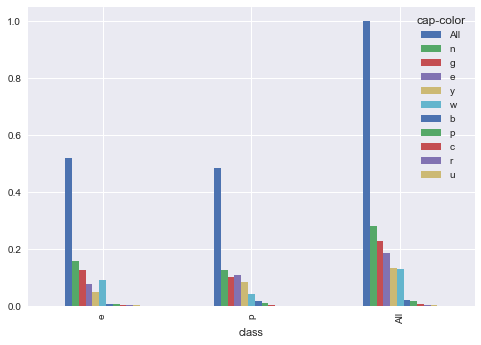

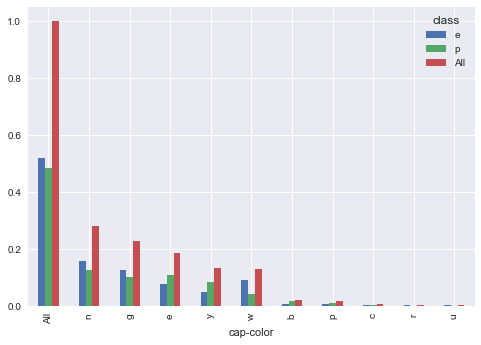

*========================================================================*
bruises(きず)
t:あり, f:なし, 
*========================================================================*


bruises,f,t,All
class,,,
e,1456,2752,4208
p,3292,624,3916
All,4748,3376,8124


bruises,f,t,All
class,,,
e,17.92%,33.87%,51.80%
p,40.52%,7.68%,48.20%
All,58.44%,41.56%,100.00%


class,e,p,All
bruises,,,
All,51.80%,48.20%,100.00%
f,17.92%,40.52%,58.44%
t,33.87%,7.68%,41.56%


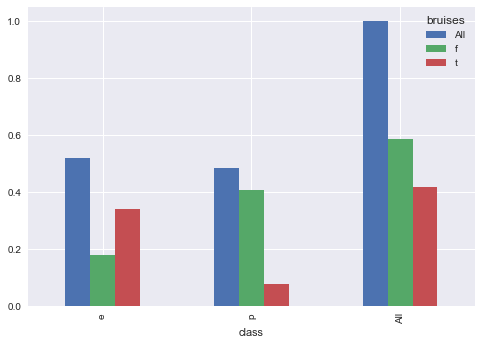

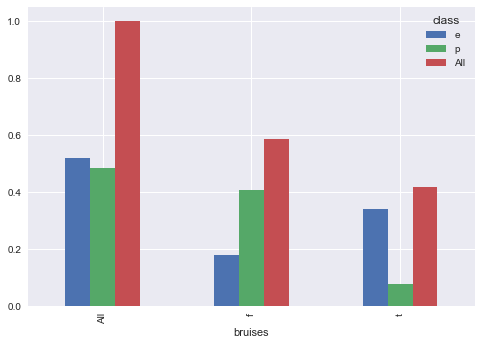

*========================================================================*
odor(におい)
a:アーモンド臭, l:アニス臭, c:クレオソート臭, y:魚臭, f:悪臭, m:かび臭, n:無臭, p:刺激臭, s:スパイシー臭, 
*========================================================================*


odor,a,c,f,l,m,n,p,s,y,All
class,,,,,,,,,,
e,400,0,0,400,0,3408,0,0,0,4208
p,0,192,2160,0,36,120,256,576,576,3916
All,400,192,2160,400,36,3528,256,576,576,8124


odor,a,c,f,l,m,n,p,s,y,All
class,,,,,,,,,,
e,4.92%,0.00%,0.00%,4.92%,0.00%,41.95%,0.00%,0.00%,0.00%,51.80%
p,0.00%,2.36%,26.59%,0.00%,0.44%,1.48%,3.15%,7.09%,7.09%,48.20%
All,4.92%,2.36%,26.59%,4.92%,0.44%,43.43%,3.15%,7.09%,7.09%,100.00%


class,e,p,All
odor,,,
All,51.80%,48.20%,100.00%
n,41.95%,1.48%,43.43%
f,0.00%,26.59%,26.59%
s,0.00%,7.09%,7.09%
y,0.00%,7.09%,7.09%
a,4.92%,0.00%,4.92%
l,4.92%,0.00%,4.92%
p,0.00%,3.15%,3.15%
c,0.00%,2.36%,2.36%


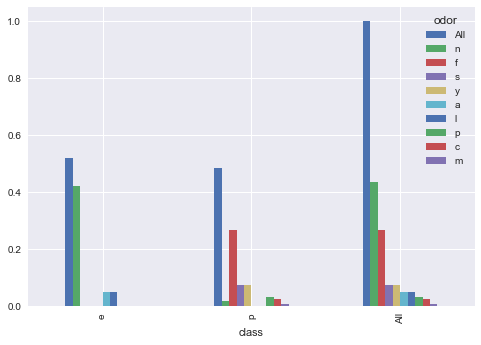

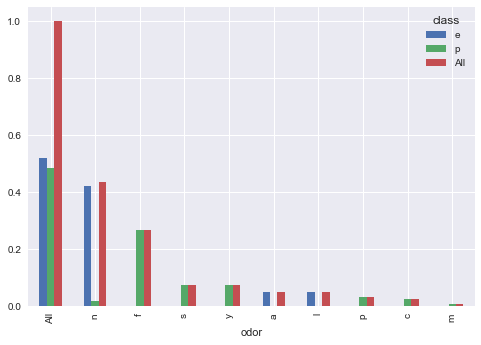

*========================================================================*
gill-attachment(ひだのつき方)
a:直性, d:垂性, f:離生, n:湾生, 
*========================================================================*


gill-attachment,a,f,All
class,,,
e,192,4016,4208
p,18,3898,3916
All,210,7914,8124


gill-attachment,a,f,All
class,,,
e,2.36%,49.43%,51.80%
p,0.22%,47.98%,48.20%
All,2.58%,97.42%,100.00%


class,e,p,All
gill-attachment,,,
All,51.80%,48.20%,100.00%
f,49.43%,47.98%,97.42%
a,2.36%,0.22%,2.58%


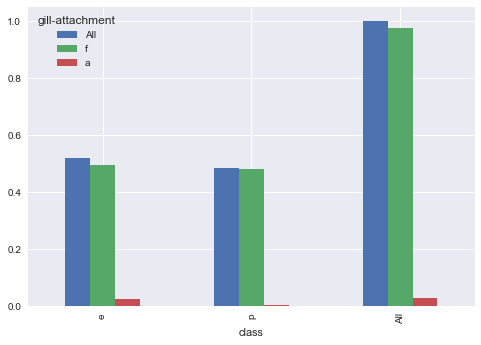

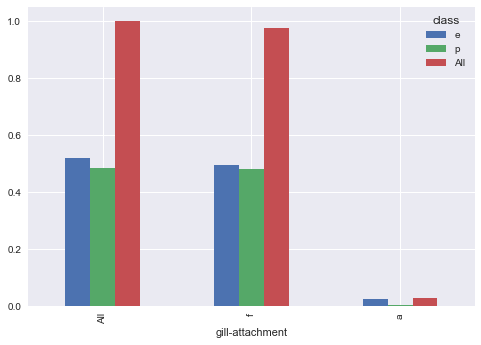

*========================================================================*
gill-spacing(ひだの間隔)
c:近い, w:密な, d:遠い, 
*========================================================================*


gill-spacing,c,w,All
class,,,
e,3008,1200,4208
p,3804,112,3916
All,6812,1312,8124


gill-spacing,c,w,All
class,,,
e,37.03%,14.77%,51.80%
p,46.82%,1.38%,48.20%
All,83.85%,16.15%,100.00%


class,e,p,All
gill-spacing,,,
All,51.80%,48.20%,100.00%
c,37.03%,46.82%,83.85%
w,14.77%,1.38%,16.15%


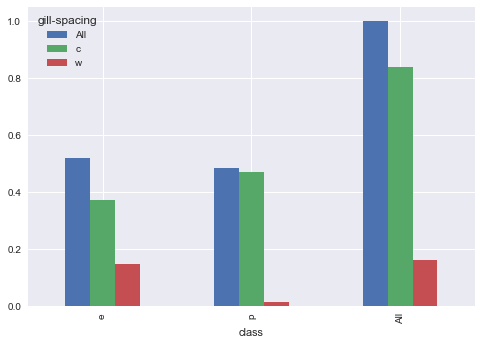

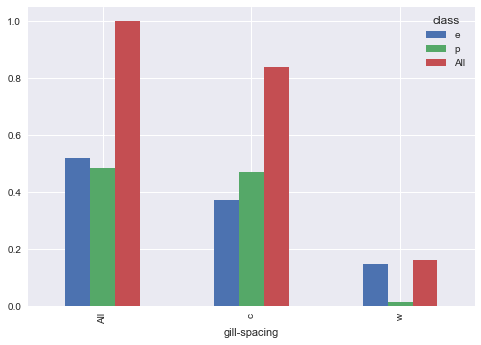

*========================================================================*
gill-size(ひだのサイズ)
b:広い, n:狭い, 
*========================================================================*


gill-size,b,n,All
class,,,
e,3920,288,4208
p,1692,2224,3916
All,5612,2512,8124


gill-size,b,n,All
class,,,
e,48.25%,3.55%,51.80%
p,20.83%,27.38%,48.20%
All,69.08%,30.92%,100.00%


class,e,p,All
gill-size,,,
All,51.80%,48.20%,100.00%
b,48.25%,20.83%,69.08%
n,3.55%,27.38%,30.92%


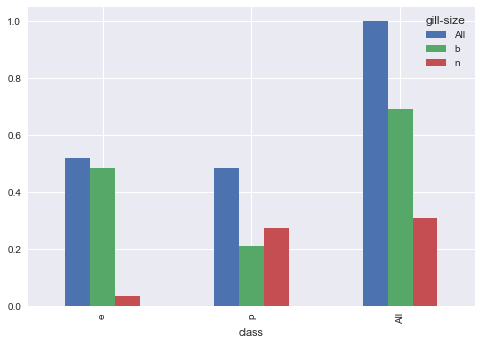

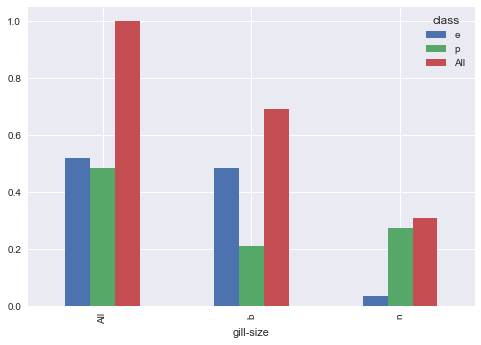

*========================================================================*
gill-color(ひだの色)
k:黒色, n:茶色, b:淡黄色, h:チョコレート色, g:灰色, r:緑色, o:オレンジ色, p:ピンク色, u:紫色, e:赤色, w:白色, y:黄色, 
*========================================================================*


gill-color,b,e,g,h,k,n,o,p,r,u,w,y,All
class,,,,,,,,,,,,,
e,0,96,248,204,344,936,64,852,0,444,956,64,4208
p,1728,0,504,528,64,112,0,640,24,48,246,22,3916
All,1728,96,752,732,408,1048,64,1492,24,492,1202,86,8124


gill-color,b,e,g,h,k,n,o,p,r,u,w,y,All
class,,,,,,,,,,,,,
e,0.00%,1.18%,3.05%,2.51%,4.23%,11.52%,0.79%,10.49%,0.00%,5.47%,11.77%,0.79%,51.80%
p,21.27%,0.00%,6.20%,6.50%,0.79%,1.38%,0.00%,7.88%,0.30%,0.59%,3.03%,0.27%,48.20%
All,21.27%,1.18%,9.26%,9.01%,5.02%,12.90%,0.79%,18.37%,0.30%,6.06%,14.80%,1.06%,100.00%


class,e,p,All
gill-color,,,
All,51.80%,48.20%,100.00%
b,0.00%,21.27%,21.27%
p,10.49%,7.88%,18.37%
w,11.77%,3.03%,14.80%
n,11.52%,1.38%,12.90%
g,3.05%,6.20%,9.26%
h,2.51%,6.50%,9.01%
u,5.47%,0.59%,6.06%
k,4.23%,0.79%,5.02%


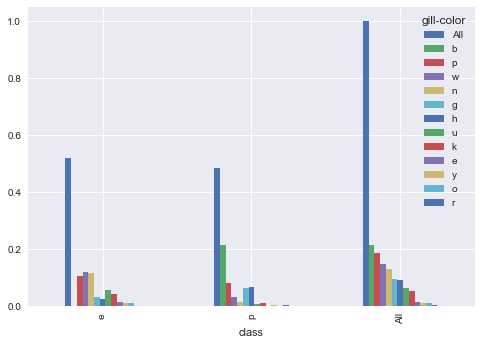

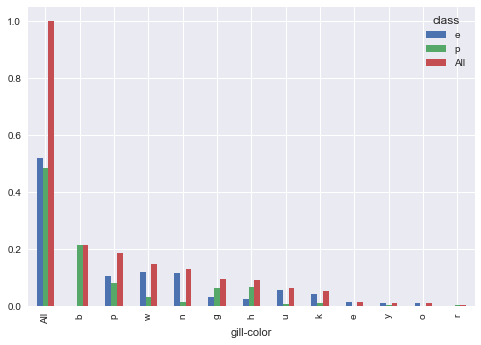

*========================================================================*
stalk-shape(柄の形状)
e:先太型, t:先細型, 
*========================================================================*


stalk-shape,e,t,All
class,,,
e,1616,2592,4208
p,1900,2016,3916
All,3516,4608,8124


stalk-shape,e,t,All
class,,,
e,19.89%,31.91%,51.80%
p,23.39%,24.82%,48.20%
All,43.28%,56.72%,100.00%


class,e,p,All
stalk-shape,,,
All,51.80%,48.20%,100.00%
t,31.91%,24.82%,56.72%
e,19.89%,23.39%,43.28%


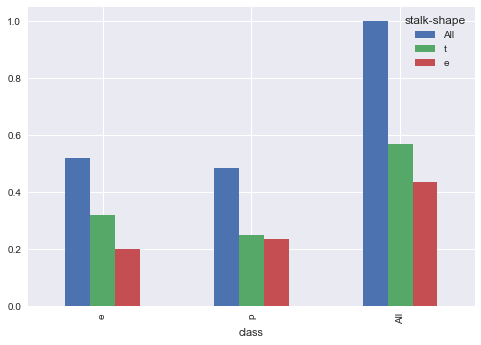

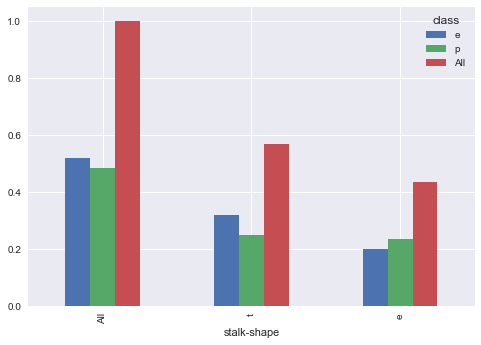

*========================================================================*
stalk-root(柄の根本)
b:球根状, c:棍棒状, u:カップ状, e:扁平状, z:根状菌糸束, r:根状, ?:欠損値, 
*========================================================================*


stalk-root,?,b,c,e,r,All
class,,,,,,
e,720,1920,512,864,192,4208
p,1760,1856,44,256,0,3916
All,2480,3776,556,1120,192,8124


stalk-root,?,b,c,e,r,All
class,,,,,,
e,8.86%,23.63%,6.30%,10.64%,2.36%,51.80%
p,21.66%,22.85%,0.54%,3.15%,0.00%,48.20%
All,30.53%,46.48%,6.84%,13.79%,2.36%,100.00%


class,e,p,All
stalk-root,,,
All,51.80%,48.20%,100.00%
b,23.63%,22.85%,46.48%
?,8.86%,21.66%,30.53%
e,10.64%,3.15%,13.79%
c,6.30%,0.54%,6.84%
r,2.36%,0.00%,2.36%


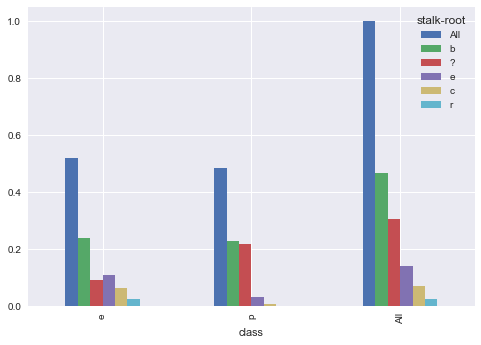

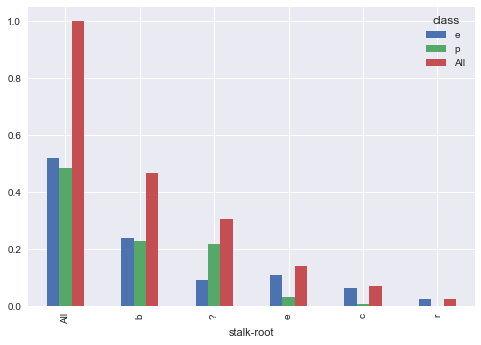

*========================================================================*
stalk-surface-above-ring(柄の表面(つばの上方部))
f:繊維状, y:鱗片状, k:絹状, s:平滑状, 
*========================================================================*


stalk-surface-above-ring,f,k,s,y,All
class,,,,,
e,408,144,3640,16,4208
p,144,2228,1536,8,3916
All,552,2372,5176,24,8124


stalk-surface-above-ring,f,k,s,y,All
class,,,,,
e,5.02%,1.77%,44.81%,0.20%,51.80%
p,1.77%,27.42%,18.91%,0.10%,48.20%
All,6.79%,29.20%,63.71%,0.30%,100.00%


class,e,p,All
stalk-surface-above-ring,,,
All,51.80%,48.20%,100.00%
s,44.81%,18.91%,63.71%
k,1.77%,27.42%,29.20%
f,5.02%,1.77%,6.79%
y,0.20%,0.10%,0.30%


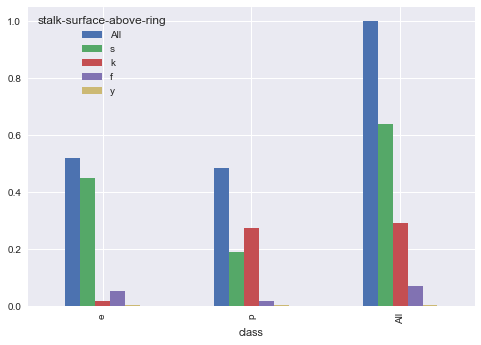

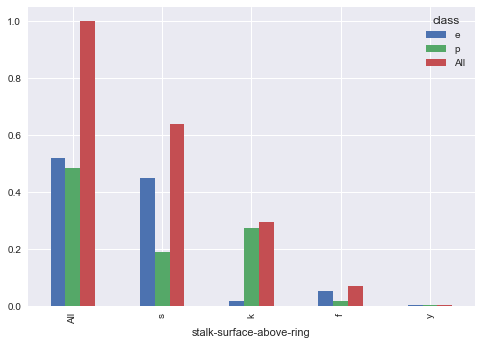

*========================================================================*
stalk-surface-below-ring(柄の表面(つばの下方部))
f:繊維状, y:鱗片状, k:絹状, s:平滑状, 
*========================================================================*


stalk-surface-below-ring,f,k,s,y,All
class,,,,,
e,456,144,3400,208,4208
p,144,2160,1536,76,3916
All,600,2304,4936,284,8124


stalk-surface-below-ring,f,k,s,y,All
class,,,,,
e,5.61%,1.77%,41.85%,2.56%,51.80%
p,1.77%,26.59%,18.91%,0.94%,48.20%
All,7.39%,28.36%,60.76%,3.50%,100.00%


class,e,p,All
stalk-surface-below-ring,,,
All,51.80%,48.20%,100.00%
s,41.85%,18.91%,60.76%
k,1.77%,26.59%,28.36%
f,5.61%,1.77%,7.39%
y,2.56%,0.94%,3.50%


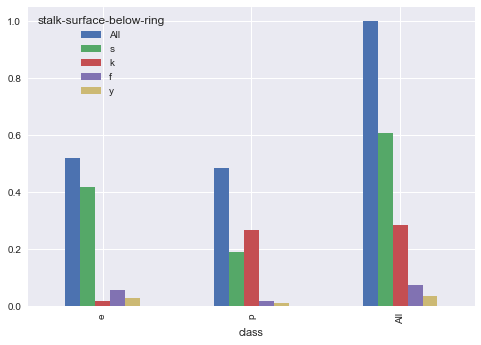

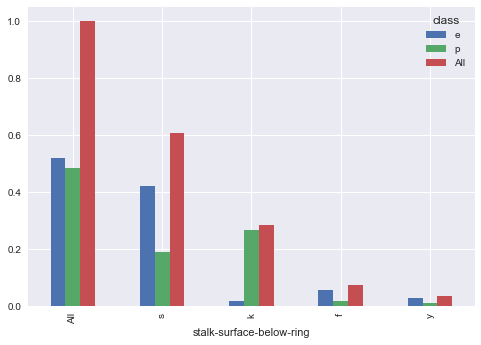

*========================================================================*
stalk-color-above-ring(柄の色(つばの上方部))
n:茶色, b:淡黄色, c:シナモン色, g:灰色, o:オレンジ色, p:ピンク色, e:赤色, w:白色, y:黄色, 
*========================================================================*


stalk-color-above-ring,b,c,e,g,n,o,p,w,y,All
class,,,,,,,,,,
e,0,0,96,576,16,192,576,2752,0,4208
p,432,36,0,0,432,0,1296,1712,8,3916
All,432,36,96,576,448,192,1872,4464,8,8124


stalk-color-above-ring,b,c,e,g,n,o,p,w,y,All
class,,,,,,,,,,
e,0.00%,0.00%,1.18%,7.09%,0.20%,2.36%,7.09%,33.87%,0.00%,51.80%
p,5.32%,0.44%,0.00%,0.00%,5.32%,0.00%,15.95%,21.07%,0.10%,48.20%
All,5.32%,0.44%,1.18%,7.09%,5.51%,2.36%,23.04%,54.95%,0.10%,100.00%


class,e,p,All
stalk-color-above-ring,,,
All,51.80%,48.20%,100.00%
w,33.87%,21.07%,54.95%
p,7.09%,15.95%,23.04%
g,7.09%,0.00%,7.09%
n,0.20%,5.32%,5.51%
b,0.00%,5.32%,5.32%
o,2.36%,0.00%,2.36%
e,1.18%,0.00%,1.18%
c,0.00%,0.44%,0.44%


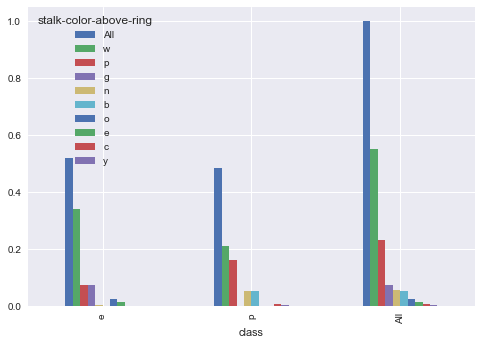

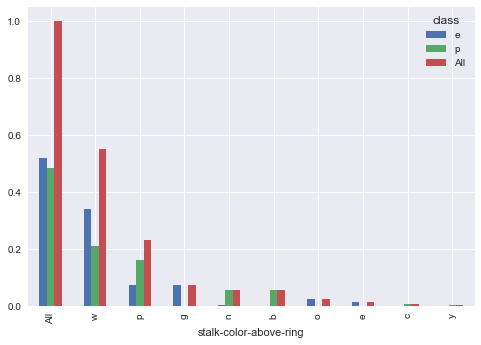

*========================================================================*
stalk-color-below-ring(柄の色(つばの下方部))
n:茶色, b:淡黄色, c:シナモン色, g:灰色, o:オレンジ色, p:ピンク色, e:赤色, w:白色, y:黄色, 
*========================================================================*


stalk-color-below-ring,b,c,e,g,n,o,p,w,y,All
class,,,,,,,,,,
e,0,0,96,576,64,192,576,2704,0,4208
p,432,36,0,0,448,0,1296,1680,24,3916
All,432,36,96,576,512,192,1872,4384,24,8124


stalk-color-below-ring,b,c,e,g,n,o,p,w,y,All
class,,,,,,,,,,
e,0.00%,0.00%,1.18%,7.09%,0.79%,2.36%,7.09%,33.28%,0.00%,51.80%
p,5.32%,0.44%,0.00%,0.00%,5.51%,0.00%,15.95%,20.68%,0.30%,48.20%
All,5.32%,0.44%,1.18%,7.09%,6.30%,2.36%,23.04%,53.96%,0.30%,100.00%


class,e,p,All
stalk-color-below-ring,,,
All,51.80%,48.20%,100.00%
w,33.28%,20.68%,53.96%
p,7.09%,15.95%,23.04%
g,7.09%,0.00%,7.09%
n,0.79%,5.51%,6.30%
b,0.00%,5.32%,5.32%
o,2.36%,0.00%,2.36%
e,1.18%,0.00%,1.18%
c,0.00%,0.44%,0.44%


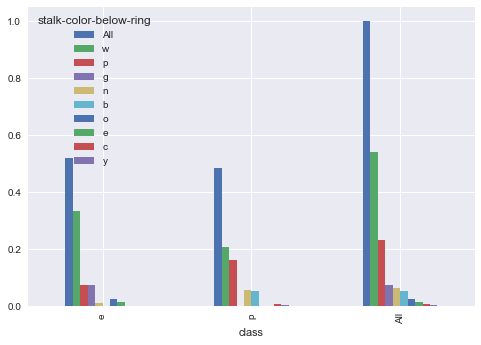

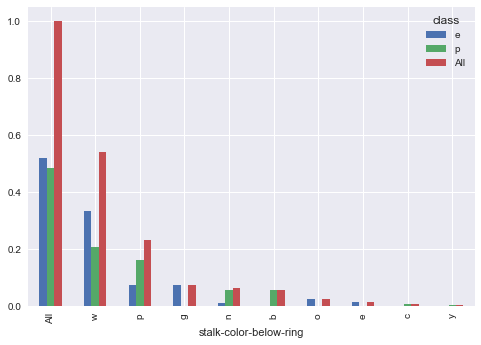

*========================================================================*
veil-type(つぼのタイプ)
p:部分型, u:全体型, 
*========================================================================*


veil-type,p,All
class,,
e,4208,4208
p,3916,3916
All,8124,8124


veil-type,p,All
class,,
e,51.80%,51.80%
p,48.20%,48.20%
All,100.00%,100.00%


class,e,p,All
veil-type,,,
p,51.80%,48.20%,100.00%
All,51.80%,48.20%,100.00%


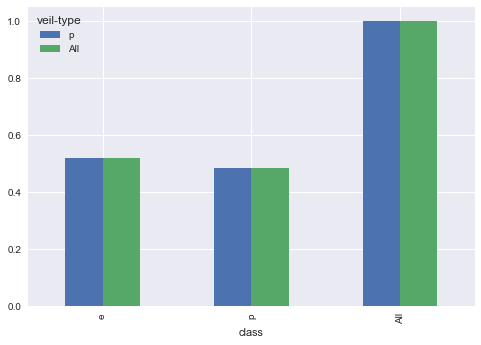

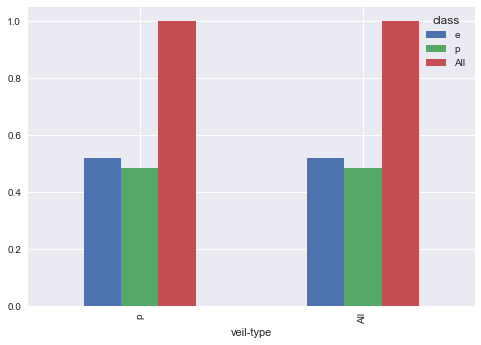

*========================================================================*
veil-color(つぼの色)
n:茶色, o:オレンジ色, w:白色, y:黄色, 
*========================================================================*


veil-color,n,o,w,y,All
class,,,,,
e,96,96,4016,0,4208
p,0,0,3908,8,3916
All,96,96,7924,8,8124


veil-color,n,o,w,y,All
class,,,,,
e,1.18%,1.18%,49.43%,0.00%,51.80%
p,0.00%,0.00%,48.10%,0.10%,48.20%
All,1.18%,1.18%,97.54%,0.10%,100.00%


class,e,p,All
veil-color,,,
All,51.80%,48.20%,100.00%
w,49.43%,48.10%,97.54%
n,1.18%,0.00%,1.18%
o,1.18%,0.00%,1.18%
y,0.00%,0.10%,0.10%


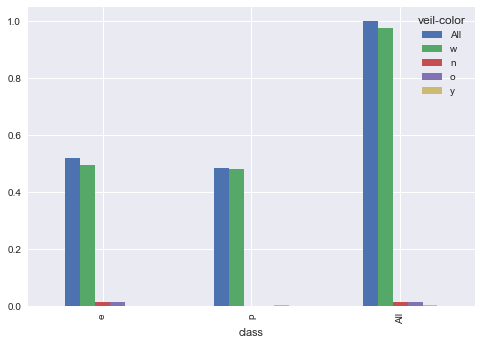

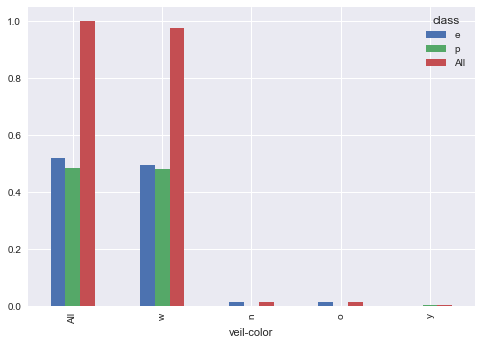

*========================================================================*
ring-number(つばの数)
n:なし, o:1, t:2, 
*========================================================================*


ring-number,n,o,t,All
class,,,,
e,0,3680,528,4208
p,36,3808,72,3916
All,36,7488,600,8124


ring-number,n,o,t,All
class,,,,
e,0.00%,45.30%,6.50%,51.80%
p,0.44%,46.87%,0.89%,48.20%
All,0.44%,92.17%,7.39%,100.00%


class,e,p,All
ring-number,,,
All,51.80%,48.20%,100.00%
o,45.30%,46.87%,92.17%
t,6.50%,0.89%,7.39%
n,0.00%,0.44%,0.44%


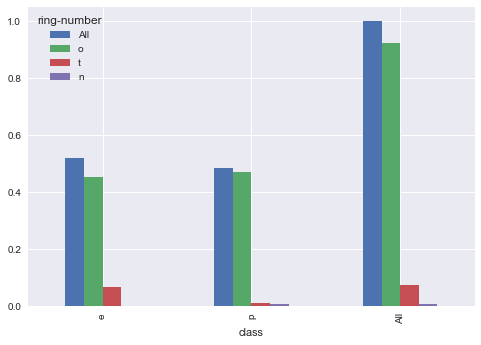

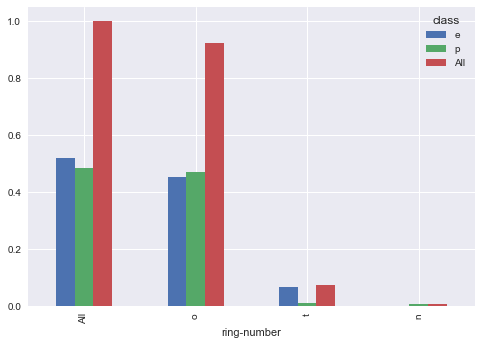

*========================================================================*
ring-type(つばのタイプ)
c:クモの巣型, e:一過型, f:口広がり型, l:大型, n:なし, p:ペンダント型, s:被覆型, z:ゾーン型, 
*========================================================================*


ring-type,e,f,l,n,p,All
class,,,,,,
e,1008,48,0,0,3152,4208
p,1768,0,1296,36,816,3916
All,2776,48,1296,36,3968,8124


ring-type,e,f,l,n,p,All
class,,,,,,
e,12.41%,0.59%,0.00%,0.00%,38.80%,51.80%
p,21.76%,0.00%,15.95%,0.44%,10.04%,48.20%
All,34.17%,0.59%,15.95%,0.44%,48.84%,100.00%


class,e,p,All
ring-type,,,
All,51.80%,48.20%,100.00%
p,38.80%,10.04%,48.84%
e,12.41%,21.76%,34.17%
l,0.00%,15.95%,15.95%
f,0.59%,0.00%,0.59%
n,0.00%,0.44%,0.44%


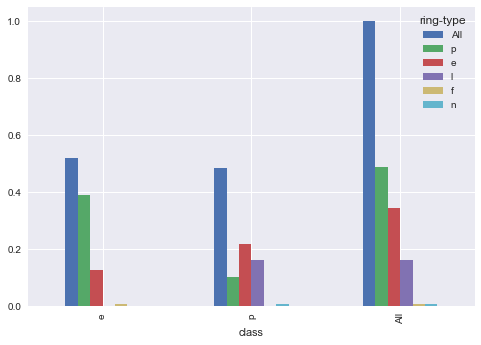

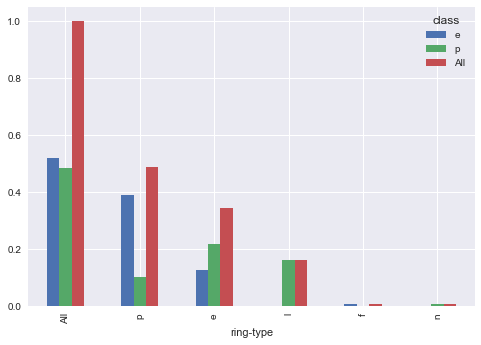

*========================================================================*
spore-print-color(胞子紋の色)
k:黒色, n:茶色, b:淡黄色, h:チョコレート色, r:緑色, o:オレンジ色, u:紫色, w:白色, y:黄色, 
*========================================================================*


spore-print-color,b,h,k,n,o,r,u,w,y,All
class,,,,,,,,,,
e,48,48,1648,1744,48,0,48,576,48,4208
p,0,1584,224,224,0,72,0,1812,0,3916
All,48,1632,1872,1968,48,72,48,2388,48,8124


spore-print-color,b,h,k,n,o,r,u,w,y,All
class,,,,,,,,,,
e,0.59%,0.59%,20.29%,21.47%,0.59%,0.00%,0.59%,7.09%,0.59%,51.80%
p,0.00%,19.50%,2.76%,2.76%,0.00%,0.89%,0.00%,22.30%,0.00%,48.20%
All,0.59%,20.09%,23.04%,24.22%,0.59%,0.89%,0.59%,29.39%,0.59%,100.00%


class,e,p,All
spore-print-color,,,
All,51.80%,48.20%,100.00%
w,7.09%,22.30%,29.39%
n,21.47%,2.76%,24.22%
k,20.29%,2.76%,23.04%
h,0.59%,19.50%,20.09%
r,0.00%,0.89%,0.89%
b,0.59%,0.00%,0.59%
o,0.59%,0.00%,0.59%
u,0.59%,0.00%,0.59%


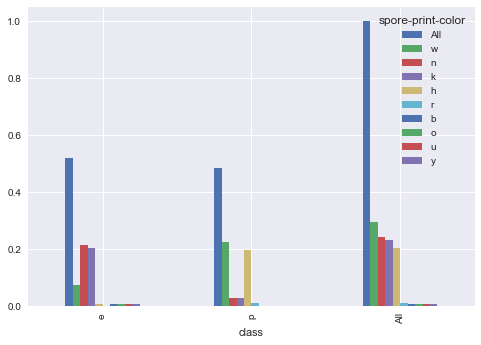

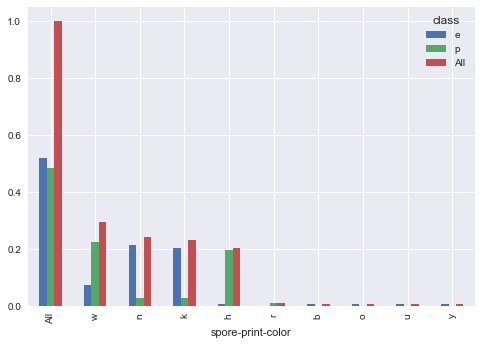

*========================================================================*
population(集団形成)
a:豊富, c:群生, n:多数, s:散在, v:少数, y:単性, 
*========================================================================*


population,a,c,n,s,v,y,All
class,,,,,,,
e,384,288,400,880,1192,1064,4208
p,0,52,0,368,2848,648,3916
All,384,340,400,1248,4040,1712,8124


population,a,c,n,s,v,y,All
class,,,,,,,
e,4.73%,3.55%,4.92%,10.83%,14.67%,13.10%,51.80%
p,0.00%,0.64%,0.00%,4.53%,35.06%,7.98%,48.20%
All,4.73%,4.19%,4.92%,15.36%,49.73%,21.07%,100.00%


class,e,p,All
population,,,
All,51.80%,48.20%,100.00%
v,14.67%,35.06%,49.73%
y,13.10%,7.98%,21.07%
s,10.83%,4.53%,15.36%
n,4.92%,0.00%,4.92%
a,4.73%,0.00%,4.73%
c,3.55%,0.64%,4.19%


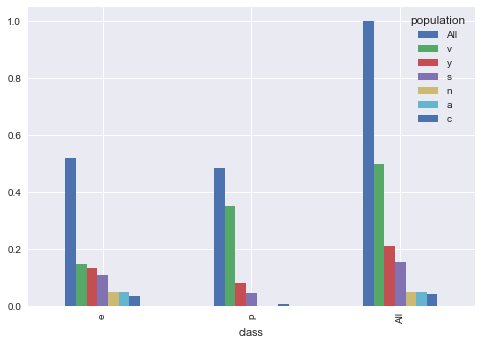

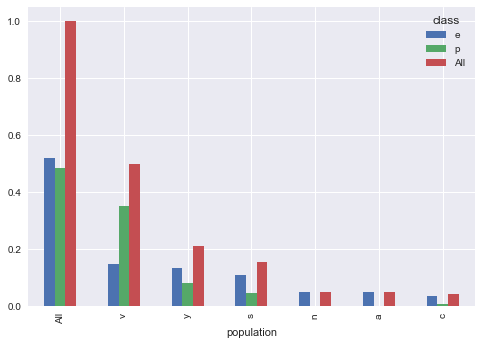

*========================================================================*
habitat(生息地)
g:芝生, l:葉, m:牧草地, p:道路, u:都市部, w:廃棄物, d:木, 
*========================================================================*


habitat,d,g,l,m,p,u,w,All
class,,,,,,,,
e,1880,1408,240,256,136,96,192,4208
p,1268,740,592,36,1008,272,0,3916
All,3148,2148,832,292,1144,368,192,8124


habitat,d,g,l,m,p,u,w,All
class,,,,,,,,
e,23.14%,17.33%,2.95%,3.15%,1.67%,1.18%,2.36%,51.80%
p,15.61%,9.11%,7.29%,0.44%,12.41%,3.35%,0.00%,48.20%
All,38.75%,26.44%,10.24%,3.59%,14.08%,4.53%,2.36%,100.00%


class,e,p,All
habitat,,,
All,51.80%,48.20%,100.00%
d,23.14%,15.61%,38.75%
g,17.33%,9.11%,26.44%
p,1.67%,12.41%,14.08%
l,2.95%,7.29%,10.24%
u,1.18%,3.35%,4.53%
m,3.15%,0.44%,3.59%
w,2.36%,0.00%,2.36%


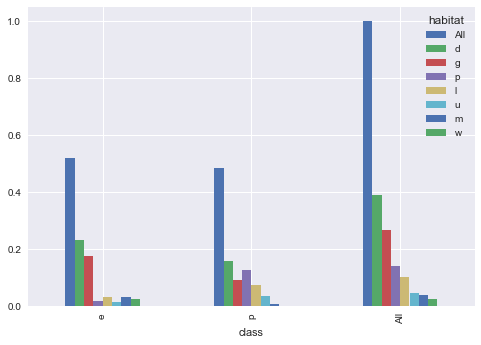

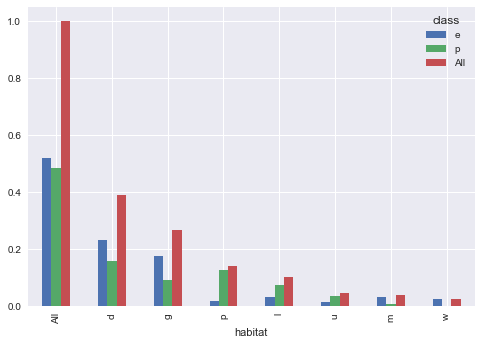

In [77]:
dict_p = {}
for col in df_data.columns:
    if col=="class":
        continue
    print('*========================================================================*')
    print('{0}({1})'.format(col, lang_trans[col]))
    for item, value in data_items[col].items():
        print('{0}:{1}, '.format(item, value), end='')
    print()
    print('*========================================================================*')
    df_c = pd.crosstab(index=[df_data["class"]], columns=df_data[col],margins=True)
    display(df_c)
    df_c = df_c / data_size
    dict_p[col] = df_c.copy()
    df_p = df_c.copy()
    display(df_p.style.format("{:.2%}"))
    df_s = df_p.T.sort_values(by=['All'], ascending=False)
    display(df_s.style.format("{:.2%}"))
    df_s.T.plot.bar()
    df_s.plot.bar()
    plt.show()

    
    

### グラフからわかること
<b>
・特徴カテゴリにより食用/毒の確率が分かれていそうな変数：<br>
</b>
　　'bruises(きず)','odor(におい)','gill-size(ひだのサイズ)','stalk-surface(柄の表面)','stalk-color(柄の色)','spore-print-color(胞子紋の色)'<br>
<b>
・食用/毒を判定する確率が半々ぐらい（クラスを決定づける情報量が小さい）の変数：<br>
</b>
　　'cap-shape(かさの形状)','cap-surface(かさの表面)','cap-color(かさの色)','stalk-shape(柄の形状)'<br>
<b>
・特定のカテゴリにデータ数が集中している変数：<br>
</b>
　　'gill-attachment(ひだのつき方)','gill-spacing(ひだの間隔)','ring-number(つばの数)','veil-type(つぼのタイプ)','veil-color(つぼの色)'<br>
</b>

### 5. 分類アルゴリズムの検討
データの特徴から分類は下記のモデルで実行する。<br>
<br>
<b>
【分類アルゴリズム】<br>
1. 単純ベイズ分類（ナイーブベイズ)
2. 決定木
</b>
単純ベイズは、今回の説明変数が互いに独立性が高そうであることと、確率変数で表すことができるため選定。<br>
決定木は、説明変数がString型の離散値であり、特徴カテゴリの取りうる値によって確率的にクラスが決定する部分が適していると感じたため選定。<br>


### 6. 単純ベイズ分類
単純ベイズ分類とは、各要素(説明変数)が独立に予測対象に影響を与えていると仮定して、ベイズの定理を活用し、最もその分類が発生する確率が高いものを予測とする手法。主に文章に利用され、文章の単語をベースにした分類に使われる。<br>

目的変数を$y$,説明変数を$x_1,…,x_n$とすると単純ベイズ分類器は下記の式となる。<br>
<br>
<b>
【単純ベイズ分類器】<br>
</b>
<br>
あるサンプルがどのクラスに属するかの確率式<br>

　$P(y|x_1,…,x_n) = P(y)\prod_{i=1}^{n} P(x_i|y)$
 
最終的にはもっとも大きな確率が割り当たるクラスに分類する。<br>

　$y = argmaxP(y)\prod_{i=1}^{n} P(x_i|y)$
<br>
<br>
【参考】<br>
ナイーブベイズ分類器を頑張って丁寧に解説してみる<br>
https://qiita.com/aflc/items/13fe52243c35d3b678b0


### 6.1 説明変数の順位付け
<br>
説明変数の中には、食用のみのデータしかない変数など、明らかに目的変数の決定に影響していない変数が存在する。<br>
ここでは、各説明変数がどの程度目的変数に影響を及ぼしているかを数値化し、単純ベイズ分類器に利用する変数を絞る。<br>
説明変数の順位付けには、各説明変数ごとの食用キノコである確率の平均情報量（エントロピー）と各説明変数ごとの毒キノコである確率の平均情報量（エントロピー）の差分で順位付けする。<br>
<br>
<b>
【エントロピー式】<br>
</b>
<br>
　$H(y) = -\sum_{i}P(x_i|y)log(P(x_i|y))$<br>
<br>
<b>
 【評価式】<br>
</b>
<br>
 　$||　H(食用) - H(毒)　||$
<br> 

In [78]:
dict_entropy_e = {}
dict_entropy_p = {}
for col, df in dict_p.items():
    df_t = df.copy()
    df_t = df_t.drop('All', axis=0)
    df_t = df_t.drop('All', axis=1)
    if col == 'stalk-root':
        df_t = df_t.drop('?', axis=1)
    entropy_e = 0
    entropy_p = 0
    for ind, row in df_t.iterrows():
        if ind == 'e':
            for p in row:
                if p != 0:
                    p = p / df['All'][ind]
                    entropy_e -= p * np.log(p)
        if ind == 'p':
            for p in row:
                if p != 0:
                    p = p / df['All'][ind]
                    entropy_p -= p * np.log(p)
    dict_entropy_e[col] = entropy_e
    dict_entropy_p[col] = entropy_p

df_e_e = pd.DataFrame(dict_entropy_e, index=['entropy_e']).T
df_e_p = pd.DataFrame(dict_entropy_p, index=['entropy_p']).T
df_e = pd.concat([df_e_e, df_e_p], axis=1)
df_e['entropy_dif'] = abs(df_e_e['entropy_e'] - df_e_p['entropy_p'])
display(df_e.sort_values(by=['entropy_dif'], ascending=False))
    
    

,entropy_e,entropy_p,entropy_dif
population,1.657920,0.808890,0.849029
odor,0.618165,1.368094,0.749928
stalk-root,1.080240,0.582624,0.497616
ring-type,0.609780,1.094916,0.485137
gill-spacing,0.597771,0.129844,0.467928
gill-size,0.249588,0.683891,0.434303
stalk-surface-above-ring,0.488359,0.822069,0.333710
gill-color,1.963573,1.648106,0.315467
ring-number,0.377694,0.143778,0.233916
stalk-surface-below-ring,0.677223,0.893227,0.216004


'population(集団形成)','odor(におい)'の情報量が大きいため、単純ベイズ分類器の説明変数にこの２変数を利用する。

### 6.2 モデル定義

In [190]:
def priori_probability(X_train, y_train):
    
    data_size = len(X_train)
    
    X_train = pd.DataFrame(X_train, columns=['population','odor'])
    y_train = pd.DataFrame(y_train, columns=['class'])
    
    # populationの確率取得
    x1 = pd.crosstab(index=[y_train['class']], columns=X_train['population'],margins=True) / data_size
    # odorの確率取得
    x2 = pd.crosstab(index=[y_train['class']], columns=X_train['odor'],margins=True) / data_size
    
    px = {'x1':x1, 'x2':x2}
    
    return px 
    

In [191]:
def basian_model(X_test, px):
    
    X_test = pd.DataFrame(X_test, columns=['population','odor'])
    
    # populationの確率変数
    e_x1 = dict(px['x1'].T['e'])
    p_x1 = dict(px['x1'].T['p'])
    
    # odorの確率変数
    e_x2 = dict(px['x2'].T['e'])
    p_x2 = dict(px['x2'].T['p'])
    
    # 初期化
    temp = pd.DataFrame({'class': ['e' for _ in range(len(X_test))]})
    
    # 食用キノコの確率
    temp['p_e'] = X_test['population'].map(e_x1) * X_test['odor'].map(e_x2) * px['x1']['All']['e']
    # 毒キノコの確率
    temp['p_p'] = X_test['population'].map(p_x1) * X_test['odor'].map(p_x2) * px['x1']['All']['p']
    
    # 確率が大きい方のクラスを選択
    temp['class'] = temp['class'].where(temp['p_e'] >= temp['p_p'] , 'p')
    
    return temp['class'].values
    

### 6.3 交差検証

In [208]:
y = df_data["class"].values
X = df_data[['population', 'odor']].values

from sklearn.model_selection import KFold

kf = KFold(n_splits=5, random_state=1234, shuffle=True)
kf.get_n_splits(X, y)

df_result = pd.DataFrame()

for train_index, test_index in kf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    px = priori_probability(X_train, y_train)
    y_pred = basian_model(X_test, px)
    df = pd.DataFrame({"y_test":y_test, "y_pred":y_pred})
    df_result = pd.concat([df_result, df], axis=0)
    
y_test = df_result["y_test"]
y_pred = df_result["y_pred"]


### 6.4 評価

In [249]:
# 混同行列
df = pd.DataFrame(confusion_matrix(y_true=y_test, y_pred=y_pred))
display(df)

total = df[0][0] + df[0][1] + df[1][0] + df[1][1]
TruePositive = df[0][0]
FalseNegative = df[0][1]
FalsePositive = df[1][0]
TrueNegative = df[1][1]
accuracy = (TruePositive + TrueNegative) / total
recall = (TruePositive) / (TruePositive + FalsePositive)
precision = (TruePositive) / (TruePositive + FalseNegative)
print('正解率\t：{0:.3f}%'.format(accuracy * 100))
print('再現率\t：{0:.3f}%'.format(recall * 100))
print('適合率\t：{0:.3f}%'.format(precision * 100))
print('F1\t：{0:.3f}%'.format(2*precision*recall/(precision+recall) * 100))

,0,1
0,4208,0
1,120,3796


正解率	：98.523%
再現率	：100.000%
適合率	：97.227%
F1	：98.594%
